# RSA

In [17]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [19]:
subj = 'subj001'
subj_date = 'subj001_10062023';
data_path = '../data'
preproc_file = f'{data_path}/interim/SIdyads_EEG_pilot/{subj_date}/{subj_date}_preproc.mat'
rdm_path = f'{data_path}/interim/PairwiseDecoding/{subj}'
annotation_file = f'{data_path}/raw/annotations/annotations.csv'

In [21]:
time = loadmat(preproc_file)['time'].squeeze()

## Load RDM

The RDMs are saved separately for each iteration (of 20). Load the RDMs and average them. Then plot the average RDM across time. This visualization is a check of the data quality. 

In [14]:
files = sorted(glob(f'{rdm_path}/*.npy'))
rdm = []
for f in files:
    #load and rearrange the matrix to match the feature rdms
    rdm.append(np.load(f))
average_rdm = np.nanmean(rdm,axis=0)
row_idx, col_idx = np.triu_indices(average_rdm.shape[0], k=1)  # k=1 excludes the diagonal
average_upper_rdm = average_rdm[row_idx, col_idx, :]

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_10113/4158494994.py:6: RuntimeWarning: Mean of empty slice
  average_rdm = np.nanmean(rdm,axis=0)


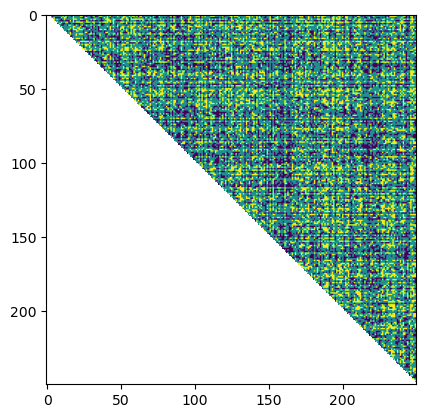

In [42]:
temp = np.load(f)
plt.imshow(temp[:,:,0])

In [39]:
plotting_data = np.nanmean(average_upper_rdm, axis=0)
ymin, ymax = plotting_data.min()-.01, plotting_data.max()+.01

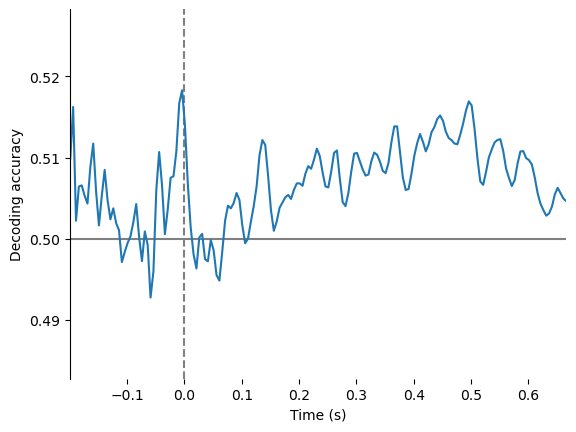

In [40]:
_, ax = plt.subplots()
ax.plot(time, plotting_data)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Decoding accuracy')
ax.vlines(x=0, ymin=ymin, ymax=ymax,
          colors='gray', linestyles='dashed', zorder=0)
ax.hlines(y=.5, xmin=time.min(), xmax=time.max(),
          colors='gray', linestyles='solid', zorder=0)
ax.set_xlim([time.min(), time.max()])
ax.set_ylim([ymin, ymax])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

## Feature RDMs

Load the feature annotations and make the RDMs. Care needs to be paid to ensure that that the order of the vidoes across the two RDMs is consistent. 

In [7]:
from scipy.spatial.distance import pdist, squareform

In [8]:
features_to_exclude = ['dominance', 'cooperation', 'intimacy']

In [9]:
df = pd.read_csv(annotation_file).set_index('video_name')
df = df.drop(columns=features_to_exclude)
df.head()

,indoor,expanse,transitivity,agent distance,facingness,joint action,communication,valence,arousal
video_name,,,,,,,,,
-YwZOeyAQC8_15.mp4,1,0.225,0.895833,0.000000,0.045455,0.700000,0.550,0.650000,0.340909
1AIVH5cEWrI_35.mp4,1,0.250,0.104167,0.075000,1.000000,0.825000,0.900,0.675000,0.340909
2-8-0-2-5-4-8-8-5028025488_7.mp4,1,0.275,1.000000,0.045455,0.050000,0.575000,0.500,0.675000,0.075000
3PJaYWt0cws_5.mp4,0,0.625,1.000000,0.725000,0.340909,0.022727,0.150,0.600000,0.400000
7-5-1-0-3-6-9-8-3775103698_9.mp4,1,0.275,0.925000,0.275000,0.636364,0.750000,0.825,0.722222,0.125000


In [10]:
feature_rdms = {}
for col in df.columns:
    arr = np.expand_dims(df[col].to_numpy(), axis=1)
    feature_rdms[col] = pdist(arr, metric='euclidean')

## Correlate Features and EEG

In [11]:
from src.tools import corr

In [12]:
rsa = {}
for key, val in feature_rdms.items():
    time_corr = np.zeros(average_upper_rdm.shape[-1])
    for t in range(average_upper_rdm.shape[-1]):
        time_corr[t] = corr(val, average_upper_rdm[:, t])
    rsa[key] = time_corr

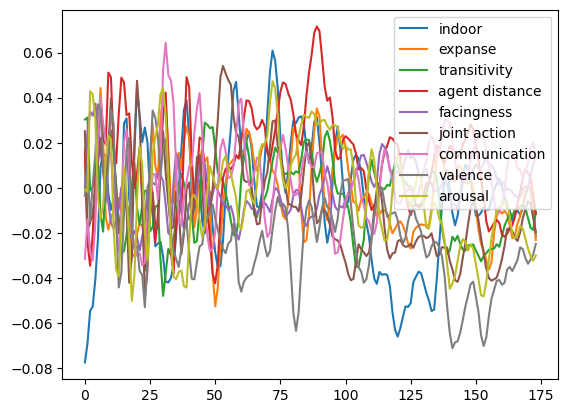

In [13]:
for key, val in rsa.items():
    plt.plot(val, label=key)
plt.legend()

In [ ]:
plt.plt